Filtered out 3 CpGs with all zero methylation fractions


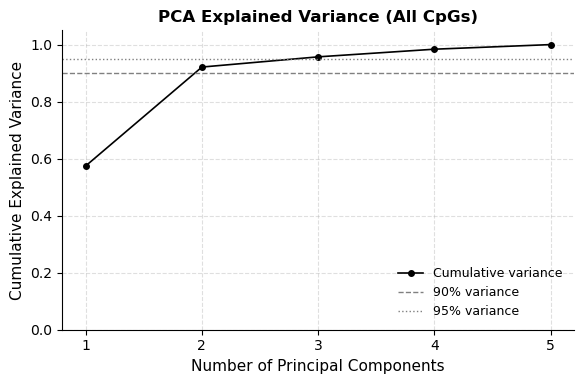

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# === Load data ===
df = pd.read_csv("cpgs_with_IR_ID.csv", sep=",")

# === Select methylation fraction columns ===
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# Filter rows with no NaNs in methylation fractions
X = df[frac_cols].dropna()

# Remove rows where all fraction values are zero
nonzero_mask = (X.sum(axis=1) > 0)  # sums > 0 means not all zeros
X_filtered = X.loc[nonzero_mask]

print(f"Filtered out {X.shape[0] - X_filtered.shape[0]} CpGs with all zero methylation fractions")

# Now proceed with PCA on filtered data
pca = PCA()
X_pca = pca.fit_transform(X_filtered)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# === Plot: Explained variance ===
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var,
    marker='o',
    markersize=4,
    linestyle='-',
    color='black',
    linewidth=1.2,
    label='Cumulative variance'
)

ax.axhline(0.90, color='grey', linestyle='--', linewidth=1, label='90% variance')
ax.axhline(0.95, color='grey', linestyle=':', linewidth=1, label='95% variance')

ax.set_xlabel('Number of Principal Components', fontsize=11)
ax.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax.set_title('PCA Explained Variance (All CpGs)', fontsize=12, weight='bold')
ax.set_xticks(range(1, len(cumulative_var) + 1))
ax.set_ylim(0, 1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', labelsize=10)
ax.legend(frameon=False, fontsize=9, loc='lower right')

plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# === Save and show ===
plt.tight_layout()
plt.savefig("pca_variance_known_icrs.pdf", format='pdf', bbox_inches='tight')
plt.savefig("pca_variance_known_icrs.svg", format='svg', bbox_inches='tight')
plt.show()

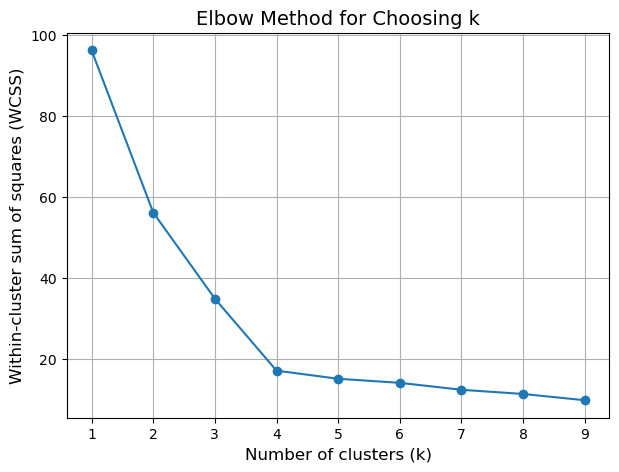

In [2]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 10)  # try k from 1 to 9

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

plt.figure(figsize=(7,5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method for Choosing k')
plt.grid(True)
plt.savefig("elbow_plot_known_icrs.pdf", format='pdf', bbox_inches='tight')
plt.savefig("elbow_plot_known_icrs.svg", format='svg', bbox_inches='tight')
plt.show()


/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


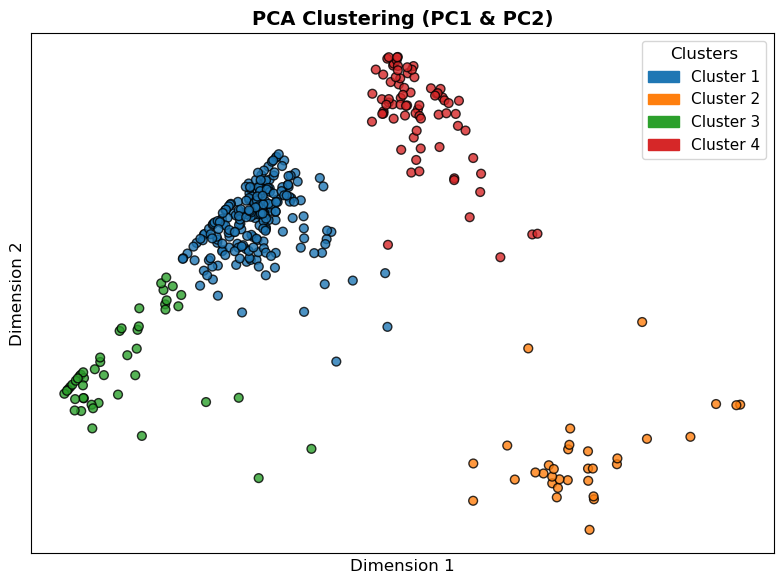

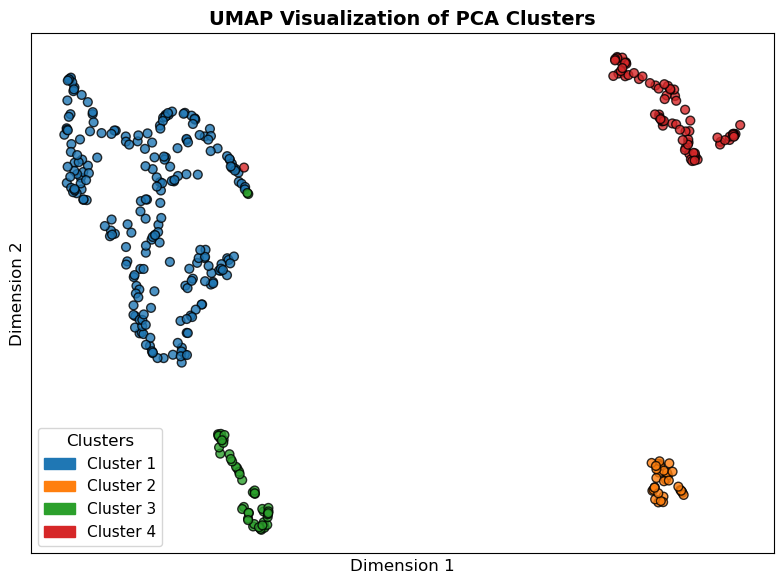

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap

# --- Load data ---
df = pd.read_csv("cpgs_with_IR_ID.csv", sep=",")

# --- Filter rows with non-null IR_ID ---
df_me = df[df['IR_ID'].notna()]

# --- Select methylation fraction columns ---
frac_cols = ['Naive_frac', 'Formative_frac', 'Primed_frac', 'Formative_Neuron_frac', 'Primed_Neuron_frac']

# --- Extract methylation fractions for each CpG site (each row) ---
X = df_me[frac_cols]

# --- Remove rows where all methylation fractions are zero ---
X = X[(X.sum(axis=1) > 0)]

# --- PCA ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X.values)

# --- KMeans clustering (4 clusters) ---
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)
clusters_named = clusters + 1  # clusters labeled 1,2,3,4

# --- UMAP on PCA components ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# --- Plotting style ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

def plot_clusters(X, labels, title, filename=None):
    plt.figure(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red
    label_colors = [colors[label - 1] for label in labels]
    
    plt.scatter(X[:, 0], X[:, 1], c=label_colors, s=40, alpha=0.8, edgecolor='k')
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(4)]
    plt.legend(handles=patches, title='Clusters', fontsize=11, title_fontsize=12, loc='best')
    plt.tight_layout()
    
    if filename:
        plt.savefig(f"{filename}.pdf", bbox_inches='tight')
        plt.savefig(f"{filename}.svg", bbox_inches='tight')
    plt.show()

# --- Plot PCA scatter ---
plot_clusters(X_pca[:, :2], clusters_named, "PCA Clustering (PC1 & PC2)", filename="PCA_clustering")

# --- Plot UMAP scatter ---
plot_clusters(X_umap, clusters_named, "UMAP Visualization of PCA Clusters", filename="UMAP_clustering")


In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap

# Load data
df = pd.read_csv("cpgs_with_IR_ID.csv", sep=",")

# Columns for methylation fractions
frac_cols = ['Naive_frac', 'Formative_frac', 'Primed_frac', 'Formative_Neuron_frac', 'Primed_Neuron_frac']

# Filter rows with valid IR_ID/ME_ID and nonzero methylation fractions
df_me = df[df['IR_ID'].notna()].copy()  # or df['IR_ID'] if your column is called that
df_me = df_me[(df_me[frac_cols].sum(axis=1) > 0)]

# Extract methylation fractions matrix
X = df_me[frac_cols].values

# PCA (3 components)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

# KMeans clustering on PCA components (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)
clusters_named = clusters + 1  # label clusters starting at 1

# Add cluster labels back to df_me
df_me['Cluster'] = clusters_named

# Select only desired columns for output
out_cols = ['Chr', 'Start', 'End', 'IR_ID', 'Cluster']
df_out = df_me[out_cols]

# Sort by Cluster before saving
df_out_sorted = df_out.sort_values(by='Cluster')

# Save sorted CSV
df_out_sorted.to_csv("cpgs_cluster_regions_known_icrs.csv", index=False)


In [24]:
import pyranges as pr
import gzip

# Load CpGs
df_cpgs = pd.read_csv("cpgs_cluster_regions_known_icrs.csv")
df_cpgs = df_cpgs.rename(columns={"Chr": "Chromosome"})
df_cpgs["Chromosome"] = df_cpgs["Chromosome"].astype(str)
df_cpgs["Start"] = df_cpgs["Start"].astype(int)
df_cpgs["End"] = df_cpgs["End"].astype(int)
gr_cpgs = pr.PyRanges(df_cpgs[["Chromosome", "Start", "End"]])

# Annotate overlaps with BED files
bed_files = {
    "TSS": "gencode_v48_TSSs.bed",
    "Promoter": "gencode_v48_promoters.bed",
    "GeneBody": "gencode_v48_gene_bodies.bed",
    "Exon": "gencode_v48_exons.bed",
    "Intron": "gencode_v48_introns.bed"
}

for feature_name, bed_file in bed_files.items():
    gr_feature = pr.read_bed(bed_file)
    
    # Expand TSS by ±1000 bp
    if feature_name == "TSS":
        df_feat = gr_feature.df.copy()
        df_feat["Start"] = df_feat["Start"] - 1000
        df_feat["End"] = df_feat["End"] + 1000
        gr_feature = pr.PyRanges(df_feat)
    
    overlaps = gr_cpgs.overlap(gr_feature)
    overlapped_intervals = set(zip(overlaps.df["Chromosome"], overlaps.df["Start"], overlaps.df["End"]))
    
    def check_overlap(row):
        return (row["Chromosome"], row["Start"], row["End"]) in overlapped_intervals
    
    df_cpgs[f"Overlaps_{feature_name}"] = df_cpgs.apply(check_overlap, axis=1)

# Annotate GeneBody_Type and Gene_Name based on GTF
gtf_file = "gencode.v48.basic.annotation.gtf.gz"
gtf_cols = ["Chromosome", "Source", "Feature", "Start", "End", "Score", "Strand", "Frame", "Attributes"]

with gzip.open(gtf_file, "rt") as f:
    gtf = pd.read_csv(f, sep="\t", comment="#", names=gtf_cols)

genes = gtf[gtf["Feature"] == "gene"].copy()
genes["gene_type"] = genes["Attributes"].str.extract(r'gene_type "([^"]+)"')
genes["gene_id"] = genes["Attributes"].str.extract(r'gene_id "([^"]+)"')
genes["gene_name"] = genes["Attributes"].str.extract(r'gene_name "([^"]+)"')

target_types = ["protein_coding", "lncRNA", "pseudogene", "miRNA"]
genes_filtered = genes[genes["gene_type"].isin(target_types)].copy()

gr_genes_filtered = pr.PyRanges(genes_filtered[["Chromosome", "Start", "End", "gene_type", "gene_id", "gene_name"]])
gr_gene_overlap = gr_cpgs.join(gr_genes_filtered)

overlap_df = gr_gene_overlap.df[["Chromosome", "Start", "End", "gene_type", "gene_name"]].drop_duplicates()
overlap_df.rename(columns={"gene_type": "GeneBody_Type", "gene_name": "Gene_Name"}, inplace=True)

df_cpgs = df_cpgs.merge(overlap_df, on=["Chromosome", "Start", "End"], how="left")
df_cpgs["GeneBody_Type"] = df_cpgs["GeneBody_Type"].fillna("None")
df_cpgs["Gene_Name"] = df_cpgs["Gene_Name"].fillna("None")

# Annotate distances to retrotransposons
rmsk_file = "rmsk.txt.gz"
rmsk_cols = ["bin", "swScore", "milliDiv", "milliDel", "milliIns",
             "genoName", "genoStart", "genoEnd", "genoLeft",
             "strand", "repName", "repClass", "repFamily",
             "repStart", "repEnd", "repLeft", "id"]

rmsk = pd.read_csv(rmsk_file, sep="\t", names=rmsk_cols, header=None, compression='gzip')

repeat_types = {
    "Alu": rmsk[rmsk["repName"].str.contains("Alu")],
    "L1": rmsk[rmsk["repName"].str.contains("L1")],
    "SVA": rmsk[rmsk["repName"].str.contains("SVA")],
    "MIR": rmsk[rmsk["repName"].str.contains("MIR")],
    "LTR": rmsk[rmsk["repClass"].str.contains("LTR")]
}

pr_repeats = {}
for rep_type, df_rep in repeat_types.items():
    df_rep_rename = df_rep.rename(columns={"genoName": "Chromosome",
                                           "genoStart": "Start",
                                           "genoEnd": "End"})
    pr_repeats[rep_type] = pr.PyRanges(df_rep_rename[["Chromosome", "Start", "End"]])

for rep_type, gr_rep in pr_repeats.items():
    nearest = gr_cpgs.nearest(gr_rep)
    df_dist = nearest.df[["Chromosome", "Start", "End", "Distance"]].rename(columns={"Distance": f"Dist_to_{rep_type}"})
    df_cpgs = df_cpgs.merge(df_dist, on=["Chromosome", "Start", "End"], how="left")
    df_cpgs[f"Near_{rep_type}"] = df_cpgs[f"Dist_to_{rep_type}"].fillna(10**9) <= 1000

# Save final annotated CpG dataframe
df_cpgs = df_cpgs.sort_values(by="Cluster")
df_cpgs.to_csv("annotated_known_icrs_clusters.csv", index=False)

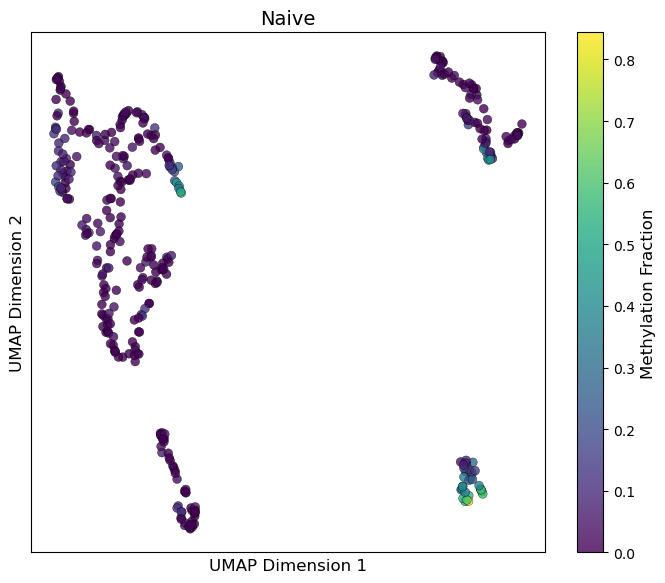

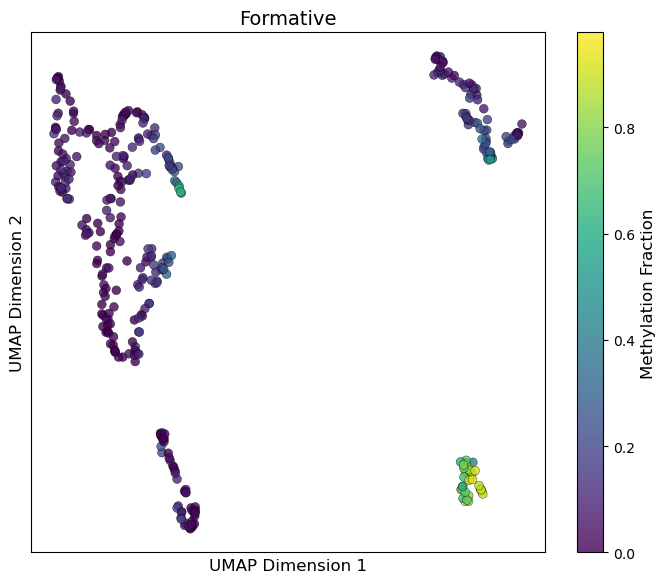

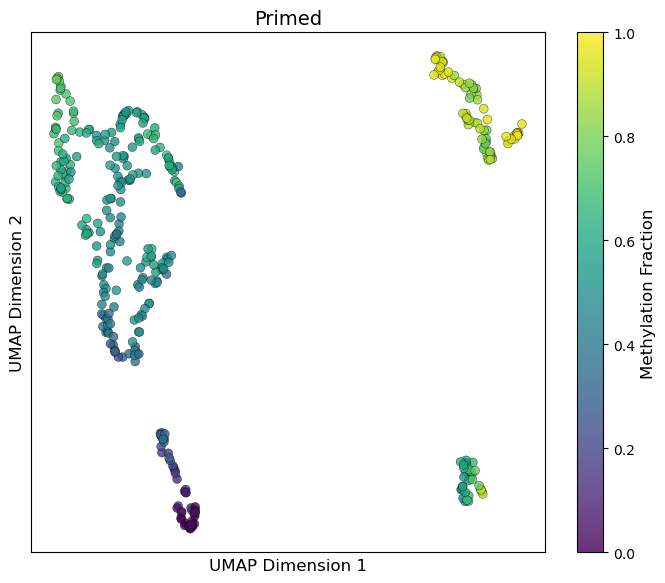

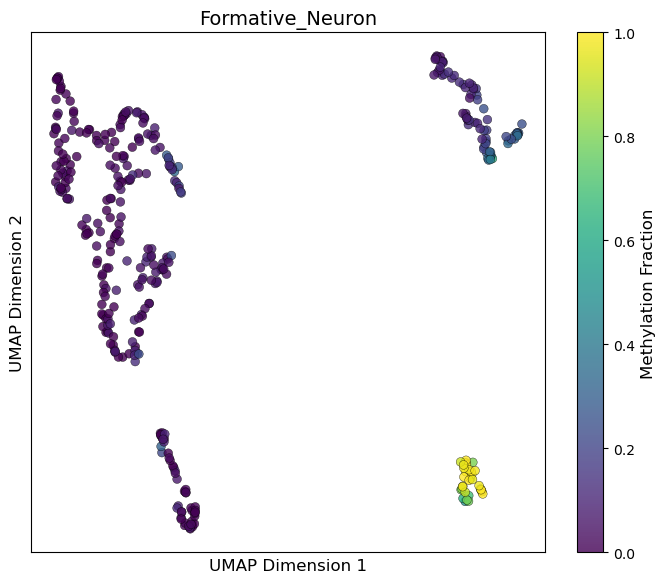

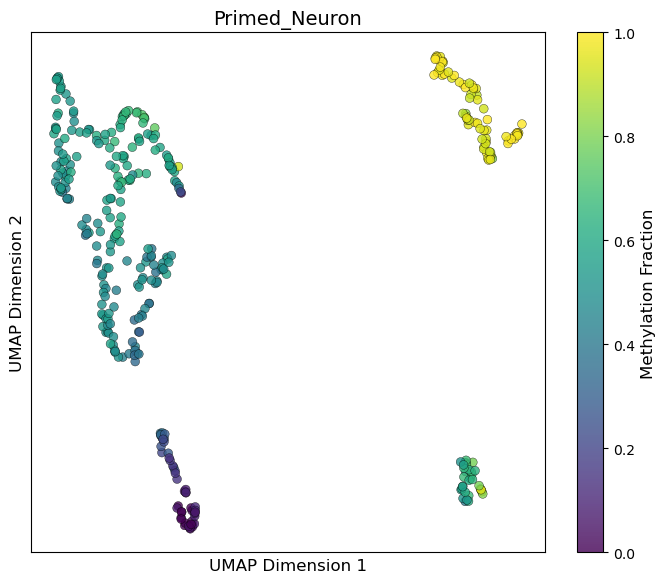

In [28]:
# Make sure X is a DataFrame, not numpy array
X = df_me[frac_cols]
X = X[(X.sum(axis=1) > 0)]  # still DataFrame

# Do PCA on X.values
X_pca = pca.fit_transform(X.values)

# UMAP on PCA
X_umap = reducer.fit_transform(X_pca)

# Plot style setup
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Now, when plotting:
for sample_col in sample_frac_cols:
    plt.figure(figsize=(7, 6))
    
    # Use X.index (filtered CpGs) to get methylation from df_me
    methylation_vals = df_me.loc[X.index, sample_col].values
    
    sc = plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=methylation_vals,
        cmap='viridis',
        s=40,
        alpha=0.8,
        edgecolor='k',
        linewidth=0.3
    )
    
    sample_name = sample_col.replace('_frac', '')
    
    plt.title(f'{sample_name}', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.colorbar(sc, label='Methylation Fraction')
    plt.tight_layout()
    
    plt.savefig(f'umap_methylation_{sample_name}.pdf', bbox_inches='tight')
    plt.savefig(f'umap_methylation_{sample_name}.svg', bbox_inches='tight')
    
    plt.show()

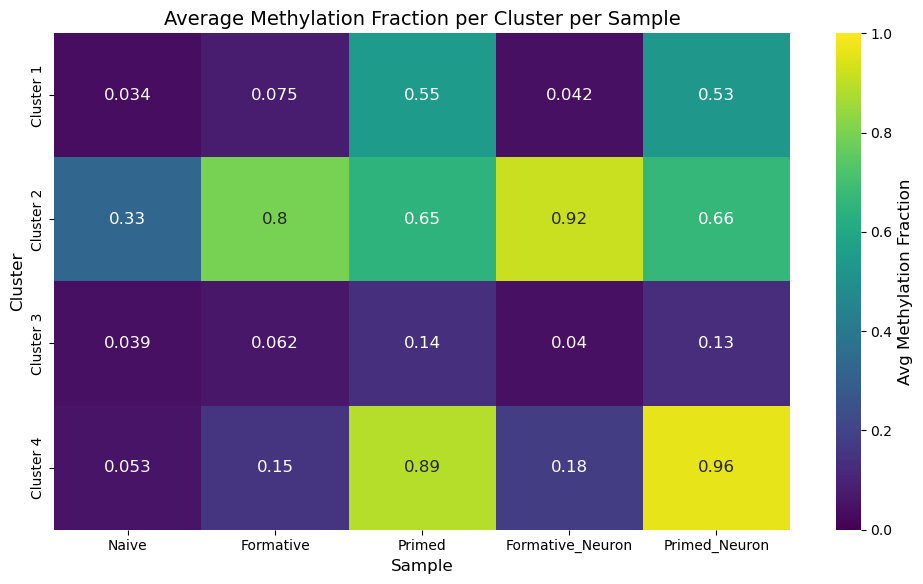

In [30]:
import seaborn as sns
# Create DataFrame for clusters aligned with X index
clusters_df = pd.DataFrame({'Cluster': clusters_named}, index=X.index)

# Combine methylation data with cluster labels
df_combined = pd.concat([X, clusters_df], axis=1)

# Group by cluster, calculate mean methylation fraction per sample
cluster_means = df_combined.groupby('Cluster').mean()

# Rename index and columns for nicer labels
cluster_means.index = [f'Cluster {i}' for i in cluster_means.index]
cluster_means_renamed = cluster_means.rename(columns=lambda x: x.replace('_frac', ''))

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_means_renamed,
    annot=True,
    cmap='viridis',
    cbar_kws={'label': 'Avg Methylation Fraction'},
    vmin=0,
    vmax=1
)
plt.title('Average Methylation Fraction per Cluster per Sample')
plt.ylabel('Cluster')
plt.xlabel('Sample')
plt.tight_layout()
plt.savefig("icr_clusters_heatmap.pdf", bbox_inches='tight')
plt.savefig("icr_clusters_heatmap.svg", bbox_inches='tight')
plt.show()

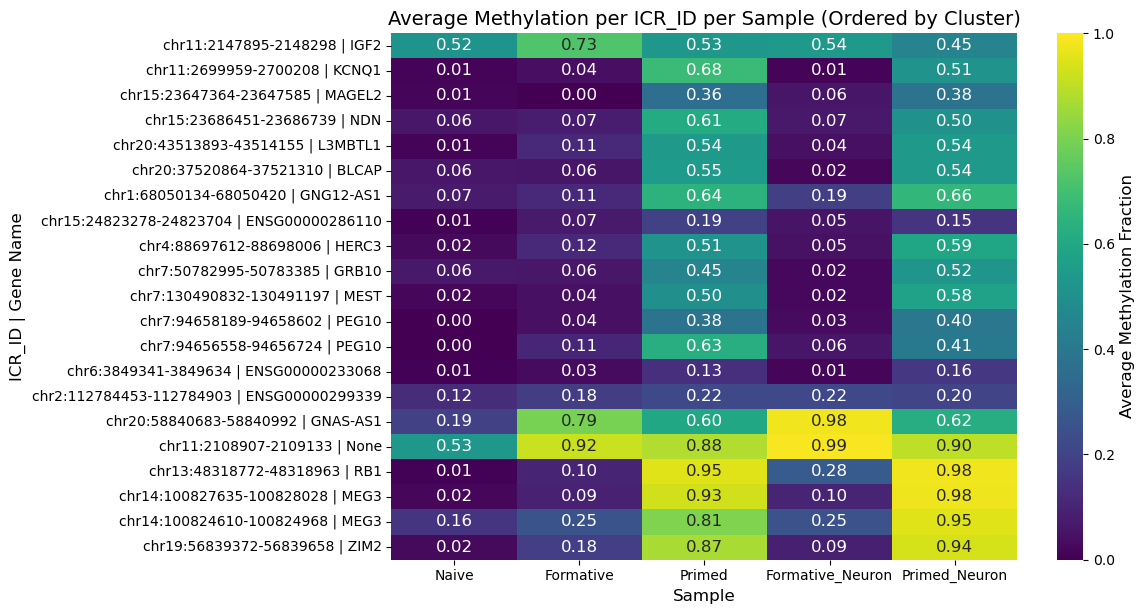

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load annotation with ME_ID, Gene_Name, Cluster info
annot_df = pd.read_csv("annotated_known_icrs_clusters.csv", sep=",")

# Ensure Cluster is numeric
annot_df['Cluster'] = pd.to_numeric(annot_df['Cluster'], errors='coerce')

# Drop missing values in key columns
annot_df = annot_df.dropna(subset=['IR_ID', 'Cluster'])

# Create ME_ID-to-Gene_Name mapping (first gene name per ME_ID)
gene_map = (
    annot_df[['IR_ID', 'Gene_Name']]
    .drop_duplicates()
    .fillna('None')
    .groupby('IR_ID')
    .first()
)

# Create ME_ID-to-Cluster mapping (mode cluster per ME_ID)
cluster_map = (
    annot_df[['IR_ID', 'Cluster']]
    .drop_duplicates()
    .groupby('IR_ID')
    .agg(lambda x: x.value_counts().idxmax())
)

# Combine gene_map and cluster_map
gene_map['Cluster'] = cluster_map['Cluster']

# Align ME_IDs from df_me to filtered CpGs in X
# Filter df_me to CpGs in X (same index)
df_me_filtered = df_me.loc[X.index]

# Add ME_ID to methylation fractions (X)
df_with_meid = X.copy()
df_with_meid['IR_ID'] = df_me_filtered['IR_ID']

# Columns with methylation fractions
sample_frac_cols = [col for col in df_with_meid.columns if col.endswith('_frac')]

# Group by ME_ID and compute average methylation fractions per sample
cluster_means_me = df_with_meid.groupby('IR_ID')[sample_frac_cols].mean()

# Rename columns to remove '_frac' suffix
cluster_means_me.rename(columns=lambda x: x.replace('_frac', ''), inplace=True)

# Keep only ME_IDs present in gene_map annotation
cluster_means_me = cluster_means_me.loc[cluster_means_me.index.isin(gene_map.index)]

# Order ME_IDs by cluster ascending
ordered_me_ids = gene_map.sort_values(by='Cluster').index

# Create combined labels for heatmap index: "ME_ID | Gene_Name"
combined_labels = [
    f"{me} | {gene_map.loc[me, 'Gene_Name']}" for me in ordered_me_ids
]

# Reorder cluster means matrix by ordered ME_IDs
heatmap_data = cluster_means_me.loc[ordered_me_ids]

# Set index to combined labels
heatmap_data.index = combined_labels

# Plot heatmap
plt.figure(figsize=(12, max(6, len(heatmap_data) * 0.3)))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Average Methylation Fraction'},
    vmin=0,
    vmax=1
)

plt.title('Average Methylation per ICR_ID per Sample (Ordered by Cluster)')
plt.ylabel('ICR_ID | Gene Name')
plt.xlabel('Sample')
plt.tight_layout()
plt.savefig("avg_methylation_per_ICRID_cluster_ordered.pdf", bbox_inches='tight')
plt.savefig("avg_methylation_per_ICRID_cluster_ordered.svg", bbox_inches='tight')
plt.show()


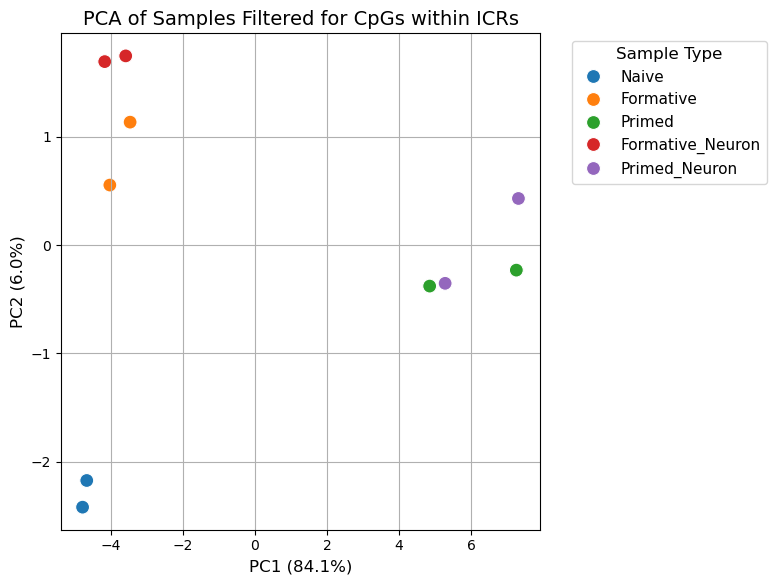

In [32]:
df = pd.read_csv('cpgs_within_imprint_regions.csv', sep=',')

# Extract fraction columns
frac_cols = [col for col in df.columns if col.endswith('_frac')]

frac_data = df[frac_cols]

# Get sample names like 'Naive_1', 'Primed_1', etc.
sample_names = [col.replace('_frac', '') for col in frac_cols]

# Transpose: samples as rows
frac_data_T = frac_data.T
frac_data_T.index = sample_names

# Fill missing values with column mean
frac_data_T = frac_data_T.fillna(frac_data_T.mean())

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(frac_data_T)

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})


# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Sample': sample_names
})

# Instead of splitting on the first underscore, split on last underscore:
plot_df['Sample_Type'] = plot_df['Sample'].apply(lambda x: '_'.join(x.split('_')[:-1]))

plt.figure(figsize=(8,6))

# Define a palette for sample types (add or adjust colors as you like)
palette = {
    'Naive': '#1f77b4',       # blue
    'Formative': '#ff7f0e',  # orange
    'Primed': '#2ca02c',     # green
    'Formative_Neuron': '#d62728',  # red
    'Primed_Neuron': '#9467bd'       # purple
}

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Sample_Type', s=100, palette=palette)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Samples Filtered for CpGs within ICRs")
plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_known_icrs.pdf", bbox_inches='tight')
plt.savefig("pca_known_icrs.svg", bbox_inches='tight')
plt.show()
